# Pooling Layer

In [29]:
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from torch import nn

## Max Poolingのスクラッチ実装

In [3]:
def max_pooling(X, kernel_size=2, stride=2):
    X_h, X_w = X.shape
    output_data = []
    for i in range(0, X_h - kernel_size + 1, stride):
        row = []
        for j in range(0, X_w - kernel_size + 1, stride):
            row.append(X[i:i+kernel_size, j:j+kernel_size].max().item())
        output_data.append(row)
    return torch.tensor(output_data)

In [6]:
# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = torchvision.datasets.MNIST('.mnist_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST('.mnist_data', train=False, download=True, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=4)

In [14]:
X, y = train_dataset[0]
X = X / 2 + 0.5  # matplotlibで表示させるために-1-1->0-1に変換する
X_ = X[0, :, :]
max_out = max_pooling(X_)

print(max_out.shape)
print(max_out)

torch.Size([14, 14])
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0706, 0.0706, 0.5333,
         0.6863, 1.0000, 0.9686, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1922, 0.9922, 0.9922, 0.9922, 0.9922, 0.9922,
         0.8824, 0.9922, 0.7647, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0706, 0.9922, 0.9922, 0.9922, 0.7765, 0.9686,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0549, 0.6039, 0.9922, 0.0078, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0431, 0.9922, 0.8824, 0.4235,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.317

AxesImage(size=(28, 28))


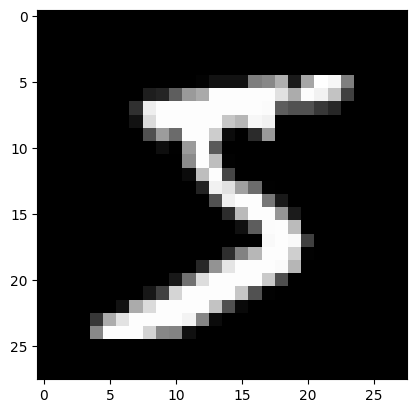

In [20]:
# 元の画像
print(plt.imshow(X_, cmap='gray'))

AxesImage(size=(14, 14))


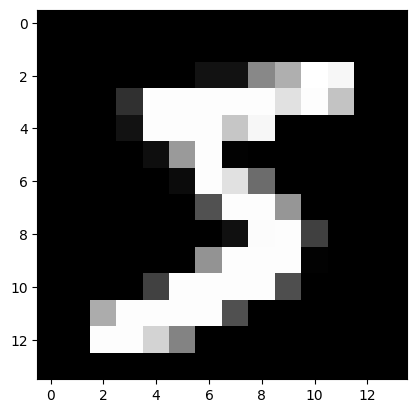

In [21]:
# max pooling後の画像。ピクセル数が半分になり、ぼやけた形状になっているのがわかる
print(plt.imshow(max_out, cmap='gray'))

In [22]:
# 上記のように元の画像をそのままmax poolingで処理することはなく
# CNN->ReLU->Poolingのように処理するので、CNN,ReLUを噛ませた後にどういう画像が表示されるか見てみる

# フィルタ
top_edge_filter = torch.tensor([[-1, -1, -1],
                               [0, 0, 0],
                               [1, 1, 1]])

# フィルタを適用する関数
def apply_filter(im, filter):  
    im_h, im_w = im.shape
    f_h, f_w = filter.shape
    output_data = []
    for i in range(im_h - f_h + 1):
        row = []
        for j in range(im_w - f_w + 1):
            row.append((im[i:i+f_h, j:j+f_h] * filter).sum().item())
        output_data.append(row)
    return torch.tensor(output_data)

# ReLU
def relu(X):
    return torch.clamp(X, min=0)

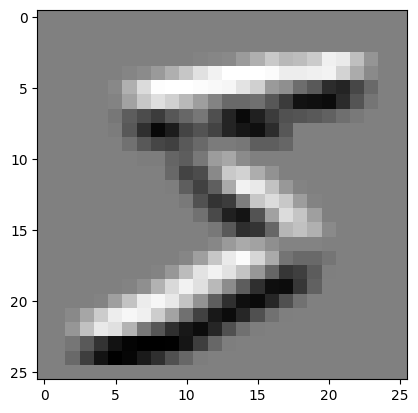

In [26]:
# 畳み込み後
conv_out = apply_filter(X_, top_edge_filter)
plt.imshow(conv_out, cmap='gray')

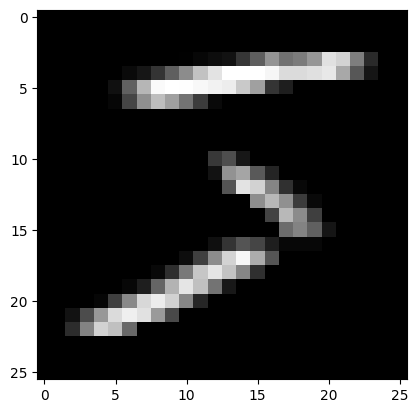

In [27]:
# ReLU
relu_out = relu(conv_out)
plt.imshow(relu_out, cmap='gray')

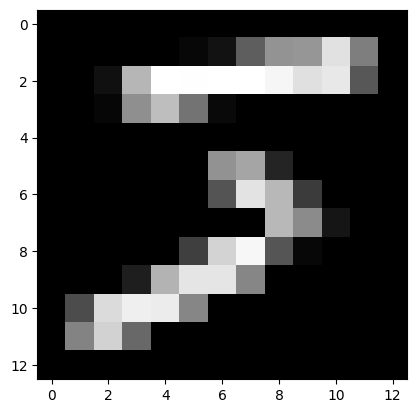

In [28]:
# max pooling
max_out = max_pooling(relu_out)
plt.imshow(max_out, cmap='gray')

## PytorchのMax pooling

Max pooling層
- nn.MaxPool2dクラスを使用して、Max Pooling層を実装することができる
    - 引数で下記を指定
        - kernel_size: Union[int, Tuple[int, ...]],
        - stride: Union[int, Tuple[int, ...], NoneType] = None,
        - padding: Union[int, Tuple[int, ...]] = 0,
- F.max_poolw2dを使用してもOK
    - 同様の引数を指定する(kernel_size, stride, padding)

In [51]:
# nn.MaxPool2dクラス　を使用
conv_model = nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1), # ReLUの後にMaxpoolingを噛ませるので、stride=1にする
    nn.ReLU(),
    nn.MaxPool2d(2, 2),  # ReLUの後にMaxPoolingを追加
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1), 
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), 
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    # 16x3x3
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), 
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    # 32x1x1
    nn.Conv2d(32, 10, kernel_size=3, stride=1, padding=1),
    # nn.MaxPool2d(2, 2),  # 最終層を2x2をmaxpoolingすることで1x1にする(Grobal Max Pooling)
    # 10x1x1
    nn.Flatten()
    # 10
    )

In [46]:
X, y = next(iter(train_loader))

X.shape

torch.Size([128, 1, 28, 28])

In [50]:
# 予測
preds = conv_model(X)

preds.shape

torch.Size([128, 10])

In [53]:
# F.max_poolw2dを使用
class ConvModel(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(32, 10, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2)
        X = F.relu(self.conv5(X))
        X = self.flatten(X)
        return X

In [54]:
conv_model2 = ConvModel(in_ch=1)

In [55]:
preds = conv_model2(X)

In [56]:
preds.shape

torch.Size([128, 10])

## Global Average Poolingのスクラッチ実装

In [63]:
class GlobalAveragePooling(nn.Module):
    def forward(self, X):
        # X:[b, c, h, w]の4rankのtensor
        # h,wのaverageを作るべき
        return torch.mean(X, dim=(2, 3), keepdim=True)

In [62]:
# (h, w)の平均を取りたいときは、.mean(X, dim=(2,3))にすれば良い
# keepdim=Trueにすることで4rankのまま保持できる
X = torch.randn((128, 3, 4, 4))
X_ave = torch.mean(X, dim=(2, 3), keepdim=True)
print(X_ave.shape)
# print(X_ave)

torch.Size([128, 3, 1, 1])


In [70]:
gap_layer = GlobalAveragePooling()
gap_out = gap_layer(X)

print(X.shape)
print(gap_out.shape)

torch.Size([128, 3, 4, 4])
torch.Size([128, 3, 1, 1])


## PytorchでGAP層

GAP層
- Pytorchには直接的なGAP層の実装はない
- torch.nn.AdaptiveAvgPool2d()を使って同様の機能を実現することが可能
    - AdaptiveAvgPool2d()は出力サイズを指定して、それに「適応」するようにプーリングする
    - torch.nn.AdaptiveAvgPool2d(1)とすることでGAPを実現できる

In [72]:
gap_layer = nn.AdaptiveAvgPool2d(1)
gap_out = gap_layer(X)
print(X.shape, gap_out.shape)

torch.Size([128, 3, 4, 4]) torch.Size([128, 3, 1, 1])


## GAP層をCNNに追加

In [81]:
# GAP追加
conv_model_gap = nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1), 
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1), 
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1), 
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), 
    nn.ReLU(),
    # 32x2x2 -> GAP -> 32x1x1
    nn.AdaptiveAvgPool2d(1),
    # 32x1x1
    nn.Flatten(),
    # 32
    nn.Linear(32, 10)
    # 10
    )

In [84]:
# GAPを追加した出力サイズの形状
X = torch.randn((128, 1, 28, 28))
out = conv_model_gap(X)
print(X.shape, out.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128, 10])


In [85]:
# GAP層を追加することで、入力サイズが変動しても対応できる
# GAPにより入力サイズを下辺にできる
X = torch.randn((128, 1, 64, 64))
out = conv_model_gap(X)
print(X.shape, out.shape)

torch.Size([128, 1, 64, 64]) torch.Size([128, 10])


In [86]:
# GAPなしのモデル
conv_model = nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 32x2x2 -> GAP -> 32 x 1 x 1
    
    nn.Flatten(),
    # # 128 -> 32
    nn.Linear(128, 10)
    # nn.Linear(32, 10)
    # 10
)

In [88]:
# 以下はエラーになる．
# 32x32など，最終的にサイズが28x28を入力にした時と同じように変化する場合はエラーにならない
X = torch.randn((128, 1, 64, 64))
out = conv_model(X)
print(X.shape, out.shape)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x512 and 128x10)